In [1]:
# %run 'mitx_plotting.ipynb'
# %run '_normal_distribution_class.ipynb'

from fractions import Fraction
# this imports the do_plots() function into the workbook, albeit in a Jupyter / Ipython way
from sympy.abc import a, b, c, d, e, f, g, h, q
import numpy as np
import scipy.stats
from sympy import Integral
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
import scipy.sparse
import scipy
import sympy as sp
import math
# from sympy.mpmath import fac
# from sympy import gamma
# import itertools
# import pyperclip
np.set_printoptions(precision = 3, linewidth=180)
# huge find:%%!
# press 'l' in command mode (esc) to toggle line numbers in a given cell, which is quite helpful for auditing
import numba
import copy
import matplotlib.pyplot as plt

# Part 1
![example markov chain](illustrations/markov_chain_example__.png)

**Preamble**

In the form $\mathbf{A}^n\mathbf x = \mathbf b$, we can represent the above graph as

$$ \mathbf{A} = \left[\begin{matrix}0.3 & 0.0 & 0.1 & 0.6 & 0.0 & 0.0\\0.7 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\0.0 & 0.75 & 0.0 & 0.0 & 0.0 & 0.0\\0.0 & 0.0 & 0.3 & 0.0 & 0.0 & 0.0\\0.0 & 0.25 & 0.4 & 0.4 & 1.0 & 0.0\\0.0 & 0.0 & 0.2 & 0.0 & 0.0 & 1.0\end{matrix}\right]$$

This is restated below, with labels.

![example tranposed Transition Matrix](illustrations/markov_chains_A.png)


*Technical note: there is some some discretion allowed in how you set up your transition matrix.  The key rules to observe are (a) always make sure that the matrix is square, (b) always make sure that the entries along the diagonal refer to self-loops, and (c) in order to make things easier later on, be sure to put all transient states next to each other, and all absorbing states next to each other.*

note that this is a column oriented approach -- all columns sum to one.  You may often see it represented in row form of:

i.e. all rows sum to one.  The transposed form is consistent with

![example tranposed Transition Matrix](illustrations/markov_chains_AT.png)




$\mathbf{x^T(A^T)}^n = \mathbf b^T$

The answers are identical and you can transpose you result if you'd rather read off your results from a column vector than a row vector.  

Either approach is ok, and the transposing of the matrix is an elementary operation.  For the most part, the convention in Linear Algebra, especially when talking about systems of equations or computing products of matrices and vectors is, where possible, to express the the algebra as a matrix vector product, *not* a row vector matrix product.  That is the convention I follow.

$\mathbf A^n\mathbf x = \mathbf b$

**Long Run Behavior**

What we are interested in is:

$\lim_{n\to \infty} \mathbf A^n \mathbf x = SteadyState$ 

If there was only one absorbing state, the vector associated with that is what b would become.  If there were no absorbing states (but certain other conditions were met -- e.g. Perron's theorem) then the steady state of the single dominant (eigen) vector is what b would become. 

Note that in all of the above cases, it does not matter what the vector x has in it, so long as its entries sum to one, and they are all non-negative (reals).  Another way of thinking about that is: in the limit, A itself will be composed solely of column vectors associated with the single dominant vector.  If we instead modelled this as $\mathbf {x^T(A^T)}^n = \mathbf b^T$, in the limit we would instead see that A is *row* vectors associated with the single dominant vector -- but again, this is a fairly minor point related to transposition.

The basic idea is that $\mathbf A$ is a map.  It is a map in the classic linear algebra sense that it acts a linear map from the finite vector $\mathbf x$ to finite vector $\mathbf b$ which is another way of saying that $\mathbf A$ acts as a linear function (in some contexts this is acceptable -- definitions of linear function seem to be inconsistent depending on the branch of math involved).  

It is also a map, in that once we get comfortable with the notation, we'll recognize the underlying graph here. Indeed in most Comp Sci classes discussing graphs / graph theory, students are instructed to store their graphs in either an adjacency matrix or adjacency list (or variant thereof).  Our graph is effectively just a weighted direction graph (digraph) and we are using an adjacency matrix to store its weights.  (In practice markov chains tend to be very sparse and hence you'd tend to use a sparse matrix implementation which combines a lot of the advantages of an adjacency matrix with those of an adjacency list, but that is beyond the scope of this writeup.) 

So, for example, say we are on starting from a mixed position that is $\frac{1}{2}$ T and $\frac{1}{2}$ U,  then our x vector would look like $\left[\begin{matrix}0.5\\0.5\\0.0\\0.0\\0.0\\0.0\end{matrix}\right]$

So, if we wanted to predict where we'd be on average 2 steps from now, the matrix algebra is 

$\mathbf A^2 \mathbf x = \mathbf b$


and while matrix vector multiplication does not commute, it is associative, so we can write the above as

$\mathbf A^2 \mathbf x = \mathbf b = (\mathbf{A A)x = A(Ax)}$

Thus if we are interested in using iterative methods to approximate the steady ending state, given an initial state, we could use some arbitrarily large number, say n = 10,000, and do $\mathbf A^{10000} \mathbf x = \mathbf b$

*Technical note: in practice you'd want to do that as a for loop implementation which is stricly faster, and will preserve sparsity.  Also note that diagonalizaton may be useful in some cases, though it is outside the scope of this writeup.*

The main point is that we can think about $A^n$ as being a probabilistic map from your current position to your next position(s), n states in the future.  

**Partitioning the Matrix **


Now let's revisit the transpose of $\mathbf A$.

![example markov chain](illustrations/AT_partioned__.png)


The above map from various starting states to various ending states has been partitioned into four pieces.

The Green portion, in the bottom right, references the 2 absorbing states.  Given that you start from Y, you only visit Y.  And given that you start in Z, you only visit Z. One consequence of this is that all values in the Yellow portion must be zero.  

The Red portion represents the probabililities associated with visiting one of the absorbing states, given that you currently are not in an absorbing state.  Finally the blue portion represents the 'main game' which are the transient states that you may begin in, but eventually must leave, as n grows large.

Based on what we've said so far, your probabilistic map must tell you to head toward the absorbing states as n grows large. 

That is: even if a 'small' n value like 100, -- if you calculate $(\mathbf  A^T)^{100}$, you'll notice that the output map tells you you're almost certain to end up in an absorbing state, no matter whether you started at T, U, V, or W.  And of course if you start at Y or Z, you are already in an absorbing state and cannot leave.  Put differently, the values of interest in the map will move from the blue zone to the red zone as n grows large.  

- - - - 

**Expected Time Until Absorbtion**

Now if we were interested in figuring out the expected number of steps until being absorbed, we could think about it as follows: 

Given that you start in T, U, V, or W (or some combination thereof -- again with probabilities summing to one), you know that you have at least one turn until absorbtion.  From there let's look at the blue slice of our map -- we'll call it $\mathbf{Blue}$.

There are mutliple ways to frame this, of course. What follows is one particular way that I find to be helpful.  

At time zero, from T, U, V, W: you for sure have at least one turn until absorbtion no matter what.  

In our example, let's say you start at W.

This means you get that one turn, then 0.6 of the time you get one more turn as shown by the map for $\mathbf {Blue}^1$ + (0.18 + 0.42 ) of the time you get another turn, as shown by the map at $\mathbf {Blue}^2$, and (0.054 +0.126 + 0.315) of the time you get another turn as shown by the map at $\mathbf {Blue}^3$...

- - - -

![example markov chain partioned](illustrations/markov_3_level_partioned_.jpg)

and so on...

Thus we have the sketch of a geometric series here.  On average, it seems that our n turns until absorbtion, can be described by the following series:

$ \mathbf { N = I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 ...}$

note that matrix multiplication distributes, so we can factor this out as follows.  

$\mathbf { N = I + Blue^1(I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 ...}$

$ \mathbf {IN = I + Blue(N)}$

$\mathbf { IN - BlueN = I}$

$\mathbf {(I - Blue)N = I}$

$\mathbf {N = (I - Blue)^{-1}I}$

$\mathbf {N = (I - Blue)^{-1}}$

- - - -
*Technical note: As outlined at the beginning of the post, we are interested in behavior in the limit and we know that everything ends up in an absorbing state. Thus everything must leave Blue, which implies*  $\lim_{n\to \infty} Blue^n = 0$ *(where 0 is just a matrix filled with zeros).  We could also approach our problem as solving a finite geometric series with n terms, then use telescoping (read: mass cancelation) to get to a position equivalent to where we left off above :  * $\mathbf {N = (I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 + ... + Blue^{n-1})}$.  Then multiply both sides by $(\mathbf {I - Blue})$, and we get: $\mathbf {(I - Blue) N = (I - Blue)(I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 + ... + Blue^{n-1}) = I} - \mathbf{Blue}^n$* and then take* $\lim_{n\to \infty} \mathbf {Blue}^n = \mathbf 0$, *which makes the $\mathbf {Blue}^n$ *term disapear for the infinite series case, leaving us with $\mathbf {(I - Blue) N = I}$, or   $\mathbf {N = (I - Blue)}^{-1}$
- - - -

or

$\mathbf N^{-1} = \mathbf {(I - Blue)}$

Thus we have $\mathbf N^{-1}$, which is easy to compute as follows.

$\mathbf N^{-1} = \begin{bmatrix}
1 & 0 & 0 & 0\\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 0\\ 
0 & 0 & 0 & 1
\end{bmatrix} - \begin{bmatrix}
0.3 & 0.7 & 0.0 &  0.0\\ 
0.0 & 0.0 & 0.75 &0.0 \\ 
0.1 & 0.0 & 0.0 & 0.3\\ 
0.6 & 0.0 & 0.0 & 0.0
\end{bmatrix} = \left[\begin{matrix}0.7 & -0.7 & 0.0 & 0.0\\0.0 & 1.0 & -0.75 & 0.0\\-0.1 & 0.0 & 1.0 & -0.3\\-0.6 & 0.0 & 0.0 & 1.0\end{matrix}\right]$


So once we invert the above matrix we get

$\mathbf  N = (\mathbf N^{-1})^{-1} = \left[\begin{matrix}1.80831826401447 & 1.26582278481013 & 0.949367088607595 & 0.284810126582278\\0.379746835443038 & 1.26582278481013 & 0.949367088607595 & 0.284810126582278\\0.506329113924051 & 0.354430379746835 & 1.26582278481013 & 0.379746835443038\\1.08499095840868 & 0.759493670886076 & 0.569620253164557 & 1.17088607594937\end{matrix}\right]$

This is a (messy) aggregation of all the portions of times we will, on average, be in a given transient state.  If we sum accross the above matrix's columns, we can get the number of times, on average, we are able to move around before being absorbed, given some starting state(s) in T, U, V, and/or W.  From a Linear Algebra perspective, we'll use matrix vector products to do this. Let's use the one's vector, denoted by: 

$\mathbf 1 = \begin{bmatrix}
1\\ 
1\\ 
1\\ 
1
\end{bmatrix}
$

We can write our expected time until absorbtion as $\mathbf{ N1 = m} = \begin{bmatrix} m_T\\
m_U\\ 
m_V\\ 
m_W
\end{bmatrix}$


Where m denotes our mean time till absorbtion, given a particular starting state. Alternatively we multiply both sides of the equation by $\mathbf N^{-1}$ and we have

$\mathbf N^{-1}\mathbf m = \mathbf 1$

In this situation, we in effect have a case where we need to solve a system of linear equations -- i.e. solve for $m_T, m_U, m_V, m_W$.  In reality, this should get us the same answer as when we inverted $N^{-1}$ but it is actually a better approach because solving a system of linear equations is generally expected to be faster than inverting a matrix, and in some cases it has much better numeric stability (though I've heard explicit matrix inversion numeric stability is much better than it once was).

To conclude: We don't need to calculate $N$, we just need to solve the following system of equations $\mathbf N^{-1}\mathbf m = \mathbf {(I- Blue)m}= \mathbf 1$
- -  -
But why might this work?  Here is an alternative interpretation of the above.  

Let's say we are starting at T.  

To evaluate where we go from there, we could simply the reference original markov chain, or our map Blue.  Either one is useful here. 

![choose a guide](illustrations/markov_either_guide__.jpg)

So if we wanted to know our expected time until absorbtion, we can approach it in a way that is similar to how we might tackle a simpler discrete distribution that exhibits memorylessness.  We could write this as follows

$E\big[AbsorbTime \big|Start = T\big] = 1 + 0.3 *E\big[AbsorbTime \big|Start = T\big] + 0.7 *E\big[AbsorbTime \big|Start = U\big]$

using our symbols from the m vector we would re-write this as 

$m_T = 1 + 0.3 m_T + 0.7 m_U$

rearranging terms we get 

$ 1 m_T - 0.3 m_T  - 0.7 m_U = 1$

and further

$ 0.7 m_T - 0.7 m_U + 0 m_V + 0 m_W = 1$

We can now repeat this process for all other transient states as follows. (Note I've indented it in a block quote in case the reader would like to skip ahead.) 

> Similarly for our expected time until absorbtion from U we could write: $ m_U = 1+  0.75 m_V$
rearrange terms $ 0m_T  + 1m_U - 0.75 m_V + 0 m_W = 1$

> For v, we could write it as: $ 1m_V = 1 + 0.1m_T + 0.3m_W $
re arrange terms and we get: $ -0.1m_T + 0 m_U + 1m_V - 0.3m_W  = 1 $

>  Finally for W we could write is as $m_W = 1 + 0.6 m_T$
re arrange terms and we get: $- 0.6 m_T + 0 m_U +_ 0m_V + 1m_W = 1$


if we collect the final equations we get
$$ 0.7 m_T - 0.7 m_U + 0 m_V + 0 m_W = 1$$
$$ 0m_T  + 1m_U - 0.75 m_V + 0 m_W = 1$$
$$ -0.1m_T + 0 m_U + 1m_V - 0.3m_W  = 1 $$
$$- 0.6 m_T + 0 m_U + 0 m_V + 1m_W = 1$$

But notice that if we work through the matrix vector multiplication, we see that the above statement is identical to saying 
$$\mathbf N^{-1}\mathbf m =\left[\begin{matrix}0.7 & -0.7 & 0.0 & 0.0\\0.0 & 1.0 & -0.75 & 0.0\\-0.1 & 0.0 & 1.0 & -0.3\\-0.6 & 0.0 & 0.0 & 1.0\end{matrix}\right] \begin{bmatrix}
m_T\\ 
m_U\\ 
m_V\\ 
m_W
\end{bmatrix}
=\begin{bmatrix}
1\\ 
1\\ 
1\\ 
1
\end{bmatrix}$$

or more succinctly

$\mathbf N^{-1}\mathbf m =  \mathbf 1$

The only difference is, in the second case our answer comes in a container called a vector. 

Thus we have two different interpretations of solving for expected time until absorbtion.  In one case we think of N as a geometric series, summing the the value of all possible iterations of our abstract object -- a map -- named Blue.  In the other case we find $\mathbf N^{-1}$ to be useful as it simply organizes a system of linear equations that we'd like to solve, even if we know very little about matrices. 




**Absorbtion Probabilities** 

The above represents a comprehensive look at expected time until absorbtion for Markov Chains.  Another key question people may ask is:  Given a particular starting state, we know absorbtion will eventually occur, but in which state will it be?  It could be Z or Y, so what kind of splits should we expect?

Again, there are very clear iterative approaches here, but let's look back at our partitioned map.

![example markov chain partioned](illustrations/AT_partioned__.png)

Let's look at the various ways we can become absorbed, using the Red portion of that map, and call it the matrix, R

![R as matrix](illustrations/markov_R__.png)

Now if only we had a map that listed, on average, the amount of times we visited every other transient state, given some starting position...

If we had such an object, we could just look up on average how many times we visit T, U, V, W given some starting position and then use our above map, R, to multiply the respective percentages.  This would allow us to calculate the portion of times that we end up in Y, and Z.  

Luckily for us, we do have such a map -- it is called $\mathbf N$.

let $\mathbf S = \begin{bmatrix} 
s_{T,Y} & s_{T,Z} \\
 s_{U,Y} & s_{U,Z}\\ 
s_{V,Y} & s_{V,Z} & \\ 
s_{W,Y} & s_{W,Z} & 
\end{bmatrix}$

(Here $\mathbf S$ is used in nod to a 'sink' in the graph.  In some sense, a sink is quite similar to an absorbing state, though there are some major technical differences relating to nilpotence of a graph connected to a sink vs an abosrbing state.  So, for example, $\mathbf S_{T,Y}$ refers to the portion of time you'll end up in the sink called Y, given a starting position in T, if we repeated this experiment many times.)

We then see that $\mathbf {S = NR}$  

And again, since inverting $\mathbf N^{-1}$ into $\mathbf N$ is costly, we may instead set this up as 
$\mathbf N^{-1}\mathbf S = \mathbf R$ and then solve the embedded system of equations to get $\mathbf S$.  

- - - 

Alternatively, if we didn't know much about matrices, we might look back to our original picture, or look to our handy blue and red maps. 

![choose a guide](illustrations/markov_either_guide2b.jpg)

For example, given that we start in V, what is the probability of ultimately being absorbed into Y?  We know it has to be at least 0.4, because V goes directly to Y with probability 0.4.  But there is also the probability that you end up in Y from visiting W at the end of your first turn or even T.  So, using the notation above, we could say 

$\mathbf S_{V,Y} = 0.4 + 0.3 \mathbf S_{W,Y} + 0.1 \mathbf S_{T,Y}$

and if we wanted to know the expected portion of times we'd end up in Z, we could write this as 
$\mathbf S_{V,Z} = 0.2 + 0.3 \mathbf S_{W,Z}+ 0.1 \mathbf S_{T,Z}$

re arranging terms we get 
$$-0.1 \mathbf S_{T,Y} + 0 + 1\mathbf S_{V,Y} - 0.3 \mathbf S_{W,Y} = 0.4$$
$$-0.1 \mathbf S_{T,Z} + 0 + 1\mathbf S_{V,Z} - 0.3 \mathbf S_{W,Z} = 0.2$$

we can repeat this process for all 3 other transient starting states and we get a system of equations that is identical to 
$\mathbf N^{-1}\mathbf S = \mathbf R$, except, once again, when we use the matrix algebra formulation our answer comes in a container-- this time in two column vectors stacked next to each other -- and we call this a matrix. 

So there you have it, two different ways to think about time until absorbtion, and respective absorbtion probabilities, all using straightforward matrix algebra.  

All of this, and I only used the term eigenvector once, and it was a parenthetical at that!

- - - 
Techincal note:  Since all probaiblities must sum to one, if you have k absorbing states, you only need to solve for the proportion of times you'll end up in specific absorbing states for k - 1 of them, and then recognize that that sum of the respective probabilities for those k - 1 terms is in fact the complement to the probability for the respective kth value.  

# Part 2
In the last post, we worked through the some expected value calculations, including the expected time until abosrbtion, for absorbing state markov chains.

In this post we'll build on that analysis to calculate the variance of time until absorbtion which is a more challenging calculation.  

Note: this post considers general cases involving finite variance.  Infinite Variance and Undefined Variance is outside the scope of this post.  You could, for example, have problematic variance calculations if some portion of the graph formed a cycle that never reaches an absorbing state.  There are workarounds from here, of course, but those too are outside the scope.

First we'll re-visit and re-interpret some of the fomula's from the prior post. 
![choose a guide](illustrations/markov_either_guide2b.jpg)



$\mathbf 1 = \begin{bmatrix}
1\\ 
1\\ 
1\\ 
1
\end{bmatrix}
$

$ \mathbf N^{-1} = \mathbf I - \mathbf{Blue}$ 

$\mathbf {N1} = \mathbf m = \begin{bmatrix} m_T\\
m_U\\ 
m_V\\ 
m_W
\end{bmatrix}$

This vector, m, had the mean time until absorbtion given a start in T, U, V, or W, and these are listed as $m_T, m_U, m_V,$ and $m_W$ respectively

Recall we originally defined N as

$ \mathbf {N = I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 ...}$

$\mathbf {N = (I - Blue)}^{-1}$


*note: for purposes of this writeup any square matrix to the zero power is the idenity matrix of comparable size.*

Indeed all we had to do was multiply it by the the ones vector h, i.e. sum accross its column space (I may want to put a picture in here) in order to get expected time until absobrtion.  We denote this as m.  We can also call this $E[n]$. 

In general we know that to get variance of some variable x, we can calulate this by $var(X) = E[X^2] - (E[X])^2 = E[X^2] - E[X]E[X] $.  So in our case, it *seems* like we'd want $var(n) = E[n^2] - E[n]E[n]$.  We basically already have the second term (note there is a technical issue involved with 'squaring' vectors that we'll address at the end).  For now we need to calculate $E[n^2]$. 

How might we go about this?  The key thing to think about this is: (a) we are interested only in starting in ${T,U,V,W}$ -- starting from an absorbing state is trivial -- and thus the number of iterations until absorbtion must be an integer  $\geq 1$, though technically there is no upper bound on this number -- it can go on until $\infty$.  Thus we might first try to reformulate our expected value calculation (and in turn our varaiance calculation) as one that we'd do for say the  geometric distribution (or a Poisson distribution).

For a distribution like this, we'd say:

$E[X] = \sum_{0}^{\infty}x * prob(x) = \sum_{1}^{\infty}x * prob(x) $

$E[X^2] = \sum_{0}^{\infty}x^2 * prob(x) = \sum_{1}^{\infty}x^2 * prob(x) $

so for our absorbing state distribution, we can use something along the lines of : 

$E[n] = \sum_{1}^{\infty}n * prob(n) $

$E[n^2] = \sum_{1}^{\infty}n^2 * prob(n) $

That is what we want.  What we currently have is:

$ \mathbf {N = I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 ...}$

rewritten slightly as 

$ \mathbf N = \mathbf{Blue}^0 + \mathbf{Blue}^1 + \mathbf{Blue}^2 + \mathbf{Blue}^3 + \mathbf{Blue}^4 + \mathbf{Blue}^5 ...$

where $\mathbf{Blue}^0: = \mathbf I$, or in sigma notation we can write that as:

$\mathbf N = \sum_{k = 0}^{\infty} \mathbf {Blue}^k$

yet what we want is something like: 
$\mathbf N = \sum_{n = 1}^{\infty}n * prob(n) $

aka:

$\mathbf N = 1 * prob(n=1) + 2 * prob(n=2) + 3 * prob(n=3) + 4 * prob(n=4) + ... $


First, how can we get to the probability of failing in the first trial?  That would be the case if our map said we were off the Blue teritory at time 1, but there at time 0.  And what about the probability of failing in the second trial (i.e. prob(n=2)? That would occur if we were off the blue map at time 2, but there at time 1.  And for the probability of failing in the third trial (i.e. prob(n=3)? That would occur if we were off the blue map at time 3, but there at time 2.  This line of reasoning continues for the probability of being absorbed at time 4, 5, 6.... 

We can write this out as 

$\mathbf {N1} = 1 * prob(n=1) + 2 * prob(n=2) + 3 * prob(n=3) + 4 * prob(n=4) + ... $

$\mathbf {N1} = 1 * (\mathbf {Blue}^0 - \mathbf {Blue}^1)\mathbf 1 + 2 * (\mathbf {Blue}^1 - \mathbf {Blue}^2)\mathbf 1 + 3 * (\mathbf {Blue}^2 - \mathbf {Blue}^3)\mathbf 1 + 4 * (\mathbf {Blue}^3 - \mathbf {Blue}^4)\mathbf 1 + 5*(\mathbf {Blue}^4  ... $

- - - -
*However, in the interest of readability, we will drop the $\mathbf 1$ for now.  We could easily factor it out from the line below, and the line below that and so on, but it becomes tedious and less readible without adding any offseting value.  note: that (where i is a scalar and h is a ones vector) * $\mathbf m = \mathbf N\mathbf 1 = E[n] = \big(\sum_{i = 1}^{\infty} i(\mathbf {Blue}^{i-1} - \mathbf {Blue}^i)\mathbf 1 \big) = \big(\sum_{i = 1}^{\infty} i(\mathbf{Blue}^{i-1} - \mathbf {Blue}^i) \big)\mathbf 1$ 

*and similarly with our squared calculation *$ E[n^2] = \big(\sum_{i = 1}^{\infty} i^2(\mathbf {Blue}^{i-1} - \mathbf {Blue}^i)\mathbf 1 \big) = \big(\sum_{i = 1}^{\infty} i^2(\mathbf {Blue}^{i-1} - \mathbf {Blue}^i) \big)\mathbf 1$ 

*Accordingly we'll drop the ones vector for now, and re-introduce it at during the final steps of calculating any expected values.*

- - -- 
$\mathbf{N} = 1 * (\mathbf {Blue}^0 - \mathbf {Blue}^1) + 2 * (\mathbf {Blue}^1 - \mathbf {Blue}^2) + 3 * (\mathbf {Blue}^2 - \mathbf {Blue}^3) + 4 * (\mathbf {Blue}^3 - \mathbf {Blue}^4) + 5(\mathbf {Blue}^4  ... $



$\mathbf N = \mathbf {Blue}^0 - \mathbf {Blue}^1 + 2\mathbf {Blue}^1 - 2\mathbf {Blue}^2 + 3\mathbf {Blue}^2 - 3\mathbf {Blue}^3 + 4\mathbf {Blue}^3 - 4\mathbf {Blue}^4 + 5\mathbf {Blue}^4 + ... $

if we simplify the above what we get is:

$\mathbf N = \mathbf {Blue}^0 + \mathbf {Blue}^1 + \mathbf {Blue}^2 + \mathbf {Blue}^3 + \mathbf {Blue}^4 + ... $

which is the same thing as our original equation for the expected time until absorbtion (where $\mathbf m = \mathbf{N1}$ i.e. $\mathbf m$ = the sum accross the column space of $\mathbf N$).


Now let's take this approach and apply it to our $E[n^2]$ calculation.  Recall that the only difference between these calculations is that, for $E[n]$ we multiply each probability by $n$, but for $E[n^2]$ we mutiply each probability by $n^2$.

Let's denote $E[n^2] = \mathbf{L1}$ (as we are close to running out of letters in the alphabet!).  As mentioned above, we'll drop the h for now, but promise to incorporate it later at the appropriate stage.  

$\mathbf L = 1^2 (\mathbf {Blue}^0 - \mathbf {Blue}^1) + 2^2 (\mathbf {Blue}^1 - \mathbf {Blue}^2) + 3^2 (\mathbf {Blue}^2 - \mathbf {Blue}^3) + 4^2 (\mathbf {Blue}^3 - \mathbf {Blue}^4) + 5^2(\mathbf {Blue}^4  ... $

$\mathbf L = 1(\mathbf {Blue}^0 - \mathbf {Blue}^1) + 4(\mathbf {Blue}^1 - \mathbf {Blue}^2) + 9(\mathbf {Blue}^2 - \mathbf {Blue}^3) + 16(\mathbf {Blue}^3 - \mathbf {Blue}^4) + 25(\mathbf {Blue}^4  ... $

if we distribute the scalars we get

$\mathbf L = 1 \mathbf {Blue}^0 - 1\mathbf {Blue}^1 + 4\mathbf {Blue}^1 - 4\mathbf {Blue}^2 + 9\mathbf {Blue}^2 - 9\mathbf {Blue}^3 + 16\mathbf {Blue}^3 - 16\mathbf {Blue}^4 + 25\mathbf {Blue}^4  ... $

this simplifies to:

$\mathbf L = 1\mathbf {Blue}^0 + 3\mathbf {Blue}^1 + 5\mathbf {Blue}^2 + 7\mathbf {Blue}^3 + 9\mathbf {Blue}^4  ... $

- - - -
*Technical note: 
With respect to the scalar coefficients for any given $\mathbf {Blue}^i$ above (except the single case of the Identity Matrix), what you have is a negative coefficient at time i and a positive coefficient at i + 1.  Because we square the coefficient value (before applying the negative or positive sign) the value for the negative coefficient is $i^2$, while the positive coefficient is* $(i+1)^2 = i^2 + 2i + 1$ *Thus when we add the two terms we get* $(i+1)^2 - i^2 = (i^2 + 2i + 1) - i^2 = 2i + 1$. *Incidentally, this equation also holds for the base case of one Identity Matrix, aka * $\mathbf {Blue}^0$

It is also (perhaps) worth noting that the largest eigenvalue for $\mathbf {Blue}$ has magnitude less than 1 (as the absorbing state(s) have the largest magnitude eigenvalue of 1), and hence the above infinite series, in effect has an arithmetic progression along with a geometric decline -- which is another way of saying that it is in the radius of convergence associated with a geometric series.  
- - - -
**(Subsequent note: there is a section tacked on at the end, "A Much Simpler...", that derives these results in a better mannner.  Nevertheless, what is shown below is your author's original take at the problem.  In general having multiple ways of solving a problem can be quite helpful so the original approaches below have been left in.)**

Our equation is thus

$\mathbf {L} = 1\mathbf {Blue}^0 + 3\mathbf {Blue}^1 + 5\mathbf {Blue}^2 + 7\mathbf {Blue}^3 + 9\mathbf {Blue}^4 + ... $

This is easy to tackle if we do a small decomposition.

Let $L = Line_{0} + 2Line_{1} + 2Line_{2} + 2Line_{3} + 2Line_{4} + ...$

Now the values of these lines are shown below


$\left.\begin{matrix}
1Line_{0}= & 1\mathbf {Blue}^0 +&  1\mathbf {Blue}^1 +& 1\mathbf {Blue}^2 + & 1\mathbf {Blue}^3+ & 1\mathbf {Blue}^4+ & ... \\ 
2Line_{1}= & 0 + &  2\mathbf {Blue}^1 + & 2\mathbf {Blue}^2 + & 2\mathbf {Blue}^3 + & 2\mathbf {Blue}^4 + & ...\\
2Line_{2}= & 0+ &  0+ & 2\mathbf {Blue}^2 + & 2\mathbf {Blue}^3+ & 2\mathbf {Blue}^4+ & ... \\
2Line_{3}= & 0+ &  0+ & 0 + & 2\mathbf {Blue}^3+ & 2\mathbf {Blue}^4+ & ...\\
2Line_{4}= & 0+ &  0+ & 0 + & 0+ & 2\mathbf {Blue}^4+ & ...\\
\vdots = & \vdots+ &  \vdots+ & \vdots + & \vdots+ & \ddots + & \ddots\\
\end{matrix}\right.$

In general, for natural numbers i = 0, 1, 2, 3, 4...:

$Line_i = \sum_{k = i}^{\infty} \mathbf {Blue}^k$

to be clear: all lines have a scalar coefficient of 2, except $Line_0$


Notice that for any arbitrary line number, i, one can construct such an upper triangular matrix with the $Line_{i}$ being in the bottom row (much as $Line_{4}$ is above).  Since we start counting at zero, such a triangular matrix will have i + 1 rows and i + 1 columns. And the final column on the right will have i + 1 entries in it of $\mathbf {Blue}^i$, with the top entry having an associated scalar of 1 and the other i entries having a scalar of 2.  Thus if we sum up each entry in the ith column we find that the aggregate scalar value for $\mathbf {Blue}^i$ must be $1(1)+ 2(i + 1 - 1) = 2i + 1$, which conforms to our original equation for L.  


- - - 

We'll use this new definition of L, As it is, every line on the right hand side has a scalar value of 2, except $Line_{0}$,  we can balance this out by adding $Line_{0}$ to both sides.  Thus we have:

$L + Line_{0} = 2*Line_{0} + 2*Line_{1} + 2*Line_{2} + 2*Line_{3} + 2*Line_{4} + ...$

Then we can divide both sides by the scalar value of 2, and we get:

$\frac{1}{2}(L + Line_{0}) = Line_{0} + Line_{1} + Line_{2} + Line_{3} + Line_{4} + ...$


Now moments ago, we stated:

$Line_i = \sum_{k = i}^{\infty} \mathbf {Blue}^k$

which is the same thing as writing:

$Line_i = \Big(\sum_{k = i}^{\infty} \mathbf {Blue}^k \Big)$

we can rewrite this as:

$Line_i = \Big(\sum_{k = i}^{\infty} \mathbf {Blue}^{k-i} \mathbf {Blue}^{i}\Big) $

we can actually pull $\mathbf {Blue}^{i}$ outside of the summation as shown below:

$Line_i = \Big(\sum_{k = i}^{\infty} \mathbf {Blue}^{k-i} \Big) \mathbf {Blue}^{i}$

and further simplify this to:

$Line_i = \Big(\sum_{k = 0}^{\infty} \mathbf {Blue}^{k} \Big) \mathbf {Blue}^{i}$

recall from the beginning of this post:

$\mathbf {N} = \sum_{k = 0}^{\infty} \mathbf {Blue}^k$

Thus we can make the substitution 

$Line_i = \big(N \big) \mathbf {Blue}^{i} = \mathbf{N} \mathbf {Blue}^{i}$
- - - -
In case the above summation notation seems opaque, here are a couple of examples using '...' notation form.

For $Line_{0}$:

$Line_{0} = \mathbf {Blue}^0 + \mathbf {Blue}^1 + \mathbf {Blue}^2 + \mathbf {Blue}^3 + \mathbf {Blue}^4 + ... $

we can re-write this as $ Line_{0} = (\mathbf {Blue}^0 + \mathbf {Blue}^1 + \mathbf {Blue}^2 + \mathbf {Blue}^3 + \mathbf {Blue}^4 + ... )\mathbf {Blue}^0 = (\mathbf N)\mathbf {Blue}^0 = (\mathbf N)\mathbf I = \mathbf N $

For another example, let's look at $Line_{3}$, we can rewrite this as:

$Line_{3} = \mathbf {Blue}^3 + \mathbf {Blue}^4 + \mathbf {Blue}^5 + \mathbf {Blue}^6 + \mathbf {Blue}^7...  $ $= (\mathbf {Blue}^0 + \mathbf {Blue}^1 + \mathbf {Blue}^2 + \mathbf {Blue}^3 + \mathbf {Blue}^4 + ... )\mathbf {Blue}^3 = (\mathbf N)\mathbf {Blue}^3= \mathbf{N Blue}^3$
- - - -
So Let's go back to our core equation for L:

$\frac{1}{2}(L + Line_{0}) = Line_{0} + Line_{1} + Line_{2} + Line_{3} + Line_{4} + ...$

and make substitutions


$\frac{1}{2}(\mathbf L + (\mathbf N)) = (\mathbf{NBlue}^0) + (\mathbf{NBlue}^1) + (\mathbf {NBlue}^2) + (\mathbf{NBlue}^3) + (\mathbf{NBlue}^4) +  ... $

factor out the common $\mathbf {N}$ on the right side of the equation and we get

$\frac{1}{2}(\mathbf{L + N}) = \mathbf N(\mathbf {Blue}^0 + \mathbf {Blue}^1 + \mathbf {Blue}^2 + \mathbf {Blue}^3 + \mathbf {Blue}^4 + ... $

The terms inside the parenthesis on the right looks very familiar.... 
Indeed we know that series itself sums to N.  We can make a substitution, accordingly.

$\frac{1}{2}(\mathbf{L + N}) = \mathbf {NN}$

$\frac{1}{2}(\mathbf {L + N}) = \mathbf N^2$

$\mathbf {L + N} = 2\mathbf N^2$

$\mathbf L = 2\mathbf N^2 - \mathbf N$

phew! that was a lot of work.  We are almost done with the variance calculation.  

so we just need to add up all of these squared values...

recall that we said 
$\mathbf 1 = \begin{bmatrix}
1\\ 
1\\ 
1\\ 
1
\end{bmatrix}
$


so $E[n^2] = \mathbf{L1} = (2\mathbf N^2 - \mathbf N)\mathbf1= (2\mathbf{NN1} - \mathbf{N1})$

now recall that we said 

$E[n] = \mathbf m = \mathbf{N1}$

where 

$\mathbf{N1} = \mathbf m = \begin{bmatrix} m_T\\
m_U\\ 
m_V\\ 
m_W
\end{bmatrix} $ and in example this is $\approx \begin{bmatrix} 4.308\\
2.880\\ 
2.051\\ 
3.585
\end{bmatrix}$


so we can make further substitutions here:

$E[n^2] = 2\mathbf{NN1} - \mathbf{N1} = 2\mathbf{N(N1)} - (\mathbf{N1}) = 2\mathbf{N(m)} - (\mathbf m) = 2\mathbf{Nm - m}$


where $VarianceVector = E[n^2] - E[n]E[n]= (2\mathbf{Nm - m}) - \mathbf m*\mathbf m$

But what does $\mathbf m*\mathbf m$ actually mean?  It is easy to get lost in the mechanics of Linear Algebra.  It is better to first start with our knowledge of probability theory and our goals.  Our goal is to calculate variance and use a basic formula that applies to individual scalars in general.  Our formula is: $var(X) = E[X^2] - E[X]E[X]$.  The fact is, we have computed all of these things already for many different scalar values for all relevant starting states and we made use of vectors as containers in the process. So we have done the hard work already and have a container that has a scalar value corresponding to $E[X^2]$ for each and every nontrivial starting state.  (And for the trivial cases we know variance is zero.)  We also have $E[X]$ for each and every starting state.  

So to take a step back: if we were just interested in knowing the variance in time until absorbtion, given starting state T, we would look back to our map (and the blue partition in particular) and see that T is on the top row.

![example markov chain](illustrations/AT_partioned__.png)

Then would look in the vector $(2\mathbf{Nm - m})$ and grab the top entry.  That corresponds to the $E[X^2]$ value for starting at T.  From this we'd subtract $m_T^2$.  And the difference would the be the variance in time until absorbtion, given a starting state = T.  

Similarly, if we were interested only in variance of time until absorbtion, given a start in U, we would look at our blue map, see U is in the second to top row, then look in the vector $(2\mathbf{Nm - m})$ and grab the second to top entry and from this subtract $m_U^2$. That gives us our the variance in time until absorbtion, given a start in U. And this process could be applied by looking in the 3rd to top row for V, and 4th to top row for W... 

So when we wrote down $m*m$ what we were actually interested in doing is computing a vector $= \begin{bmatrix} m_T*m_T\\
m_U*m_U\\ 
m_V*m_V\\ 
m_W*m_W
\end{bmatrix} = \begin{bmatrix} m_T^2\\
m_U^2\\
m_V^2\\ 
m_W^2\\
\end{bmatrix}$

Put differently we were interested in doing element-wise multiplication within the vector.  This is *not* the canonical type of matrix multiplication or vector multiplication.  It goes by the name of Hadamard product though it can be thought of as a diagonal matrix with the m vector along the diagonal, and then squaring that diagonal matrix, as discussed in the technical note below.

*techincal note: we know that $E[n] = \mathbf m$, but under the traditional definition of matrix multiplication (and where a vector is interpretted as a 1 column matrix) $\mathbf m * \mathbf m$ would not be an allowed operation, as the k inner lenghts do not line up.  I.e. one could mutliply $\mathbf m^{T}\mathbf m$ or $\mathbf {mm}^{T}$ thought not $mm$.  However these allowed operations do not make sense given our underlying understanding of the definition of variance.  What we really want to do here is square every element inside the vector. There are two ways to effect this.  The first is by representing this with: $\mathbf m \circ \mathbf m$ where* $\circ$ *represents the Hadamard  product (i.e. element wise mutliplication) between these two vectors.  An alternative representation is to let* $\mathbf D = diag(\mathbf m)$.

*It is a matter of personal preference as to how to represent this.  For computational purposes, using the Hadamard  product is the most straightforward.*

So we can then re-write our equation as:

$VarianceVector = 2\mathbf{Nm - m - D}^2 \mathbf1$

where 

$\mathbf D = diag(\mathbf m) = \begin{pmatrix}
m_T & 0 & 0 & 0\\ 
0 & m_U &  0& 0\\ 
0 & 0 &  m_V& 0\\ 
0 & 0 &  0& m_W
\end{pmatrix}$

*note that any diagonal matrix times a diagonal matrix is itself a diagonal matrix, and the ones vector, h, 'extracts' the non-zero elements of any diagonal matrix (i.e. elements along the diagonal) and puts them in a vector, thus* $\mathbf{D1} = \mathbf m$ and $\mathbf D^2\mathbf h = \mathbf m \circ \mathbf m  $.  *Technically there are nuances around using non-square diagonal matrices, but this post only needs to consider the nice form of a diagonal matrix -- i.e. a square matrix with all non diagonal entries equal to 0.*


And this is our answer

$VarianceVector = 2\mathbf{Nm - m - D}^2 \mathbf 1 = 2\mathbf{Nm - m - (m \circ m)}$

- - - -

From a linear algebra perspective we are done.  

However, if, as part of our computations, we did not want to explicitly invert $\mathbf N^{-1}$, then we could a small bit more algebra to get the following:

$VarianceVector = 2\mathbf{Nm  + (- m - D^2 1)}$

$VarianceVector = part1_{vector} + part2_{vector}$ i.e. we can split the VarianceVector into two separate parts, where 

$part1_{vector} = 2 \mathbf{Nm}$

and $part2_{vector} = \mathbf{- m - D}^2 \mathbf 1 = -\mathbf{m - (m \circ m)}$

$part2_{vector}$ is thus easy to calculate.  

for $part1_{vector}$, we can multiply both sides by $\mathbf{N}^{-1}$

$\mathbf N^{-1}part1_{vector} = 2 \mathbf m$

which is the same as solving a system of linear equations, except the right hand side is now $\mathbf m$ --not $\mathbf 1$ or $\mathbf R$, as it was in the original posting here on expected values.

Hence we solve for $part1_{vector}$ and add $\big(- \mathbf{m - (m \circ m)}\big)$ to this to get our VarianceVector.   



Now for some thoughts on expected values and variances with a mixed starting state:

If instead of starting at state T with 100% certainty, what if we started at state T with 55% confidence and state U with 45% confidence?  (Alternatively put, what if we on average were at state T 55/100 times and state U 45/100 times, when this process starts?)  In order to solve for this, we use the Law of Total Expectation (or Law of Iterated Expecations) and the Law of Total Variance.  

![markov chains 3 parts](illustrations/markov_3_map.png)
# the above, bottom right picture should be updated to use a bold one, not an h to denote the ones vector

The Law of Iterated Expectations tells us that we can simply look at the above and compute the expected value of such a situation as being $ \approx 0.55 * 4.3083 + 0.45* 2.8797 \approx 3.6654$.  

And what if we had 30% confidence we were on T and 70% confidence we were on U?  Then the expected time until absorbtion $\approx  0.3 * 4.3083 + 0.7 * 2.8797 \approx 3.3083$. This number appears to be expected value given a start at T, but minus one, hmmm... 

Now what if we were 60% confident that we were in T and 40% confident that we were in Y?  Then our expected time until absorbtion $\approx 0.6*4.3083 + 0.4 *0 \approx 2.585$ which appears to be exactly one less than the expected value if we started at W.  

These are not coincidences. Indeed if we look back at our map (using the Blue and Red portions above or the graphical representation), we see that if we start at W, then on average, we will be 60% in T and 40% in (absorbing state) Y after one turn.  Thus the 0.6 T, 0.4 Y splits are the longrun equivalent to the position of having started at W and now being at time + 1.  

If we look at the below side by side distributions -- either the Probability Mass Functions (PMFs), or the Cumulative Distribution Functions (CDFs),  we notice that they are identical except the second one (Start One Turn After W) has been shifted to the left by one.  That is, if one starts at T, U, V, or W, the first time some portion is absorbed must be at a step $\geq 1$ -- i.e. nothing interesting happens at time zero..  If we start looking at time 1,  then all of the same 'interesting' things happen, just one step sooner -- which is another way of saying that the second distribution has been shifted one step to the left.  


![distribution comparison](illustrations/markov_dist_comparison.png)

*technical note: the probability of being 'fully' absorbed goes to 1 in the limit of $\lim_{n \to \infty}$.  When using iterative methods we naturally run for only a finite number of steps (akin to truncating an infinite series).  However the process moves very quickly.  Discussions of convergence have many different tools that may be used including Chebyshev's inequality, or use of the largest eigenvalue less than one.  Your author has determined that ~ 50 iterations is enough for this example.*




So when we look at these left hand side vs right hand side  absorbtion probability distributions , it makes sense that they have identical means, except the one on the right is $mean_{left} - 1$.  The  more subtle point is that the variance is the same in both cases.  Since left vs right the distributions above are identical except one has been shifted, then the dispersion around the mean value is identical in both cases.  And that is all a variance calculation is: a dispersion around the mean calculation using, essentially, a length norm 2 (i.e. squared distance measure).  

Note that you can verify this from defintions of variance.  Alternatively we can check this using the Law of Total Variance.  

Indeed the Law of Total Variance allows us calcuate the variance from a mixture of any and all starting states (though I will note that we don't need it for a starting state that is that only has a degenerate form of randomness afterwards, including all absorbing states, since those definitionally have zero variance in absorbtion time).

The Law of Total Variance:

$TotalVariance = ExpectedVariance + VarianceOfExpectations$

So if the reader was interested in finding the variance in time until absorbtion when we were 25% confident we are in T, 25% confident in U, 25% confident in V, and 25% confident in W, we could solve for this using the Law of Total Variance.  



**Alternative Derivation of VarianceVector using Law of Total Variance **

# Note: This section was written a while back using somewhat different notation.  It serves as a rather unpleasant second derivation of variance -- the slightly different notation (esp. use of h for ones vector, and non bolded matrices and vectors) has not been updated.  This section is of interest as a way to check the work above, but other than that, it may be safely skipped.  If you do skip it, go straight to the section titled "Conclusion"

What is interesting is that if we were unable to derive $VarianceVector$ at the beginning of this article, we could exploit the Law of Total Variance evaluated at time = 1, in order to solve for the $VarianceVector$.  Your author found this approach to be a bit tedious, and unfortunately it involves manipulating quite a few symbols, though a sketch of the derivation will be provided.  

If we looked at this say row W at a time zero, for $Variance(start = W)$

recalling our defintion of the Law of Total Variance: $TotalVariance = ExpectedVariance + VarianceOfExpectations$


The equation would be 

$TotalVariance(start = W) = \big(1*TotalVariance(start = W) \big) + \big(1 * (m_W - m_W)^2 \big)$

$TotalVariance(start = W) = \big(TotalVariance(start = W) \big) + \big(1 * (0)^2 \big)$

$TotalVariance(start = W) = TotalVariance(start = W) + 0$

thus 

$TotalVariance(start = W) = TotalVariance(start = W)$

which is not very helpful.  


However when we looked at the side by side distributions, we observed that Variance for W is the same at time 0 and time 1.... let's substitute in on the right hand side the variance calculation at time 1, again using the Law of Total Variance

$TotalVariance(start = W) = \big(0.6*TotalVariance(start = T) + 0.4*(TotalVariance(start = Y)  \big) + VarianceOfExpectations$

we know that total variance for starting at  Y is zero, so we can remove it from the equation. Then we can simplify this to:

$-0.6*TotalVariance(start = T) + 1 * TotalVariance(start = W) =  VarianceOfExpectations$

If we repeat this for T, U, V, we get:

$N^{-1}VarianceVector = VarianceOfExpectationsVector$

** *Unfortunately, working through the $VarianceOfExpectationsVector$ involves a somewhat tedious number of symbol manipulations.  A walkthrough is outlined below.  If you are not interested in such a derivation, consider this the end of the post!* **

- - - 
First, here is a quick overview of symbols that will be used for the rest of the article.  Note: everything below is substantially the same as before, however some tweaks had to be made.  There is no point in solving for the variance given a start at time Y or variance given a start at time Z -- we know that in both of those cases the variance is zero because they are absorbing states. However, if we work through the terms in VarianceOfExpectations we at least initially need some references to Y and Z in certain vectors.  Thus what we are left with is below.  

![final symbols review](illustrations/markov_final_symbols_review2.png)

In short, $A^{T}$ had the green and yellow portions sliced off, we have our existing ones vector, h, but there is a new longer ones vector, q, that is just h with two more ones tacked on (i.e. to accomdate a larger mutliplying matrix that contemplates T, U, V, W, Y, Z), and similarly our mean vector m is the same, but we also needed to put in place vector p, which is m, along with the means of Y and Z tacked on (which are of course both zero).  Finally, because this approach involves dealing with the Variance of Expectations, there are a lot of squared terms that must be dealth with.
- - -

$VarianceOfExpectationsVector$ has 4 rows, just like $N^{-1}$ and $VarianceVector$.  We approach $VarianceOfExpectationsVector$ by examining some arbitrary row, i, in it.  (As a review: looking back at our map, we see that T is in row 0, U is in row 1 and so on -- thus $a_3^{T}$ refers to the bottom row of our blue and red map in $A^T$ and $m_3$ refers to the scalar value in the bottom slot of m, aka $m_W$.  Also note that there we have $\beta$ states in total (where $\beta = 6$ in our example) )

Thus for the value of the scalar in the ith row of $VarianceOfExpectationsVector$, we have:

$VarianceOfExpectationsVector_i = \sum_{j = 0}^{\beta - 1} (p_j - (p_i - 1))^2 * ProbabilityOfGoingInOneStep_{fromState_i->State_j}$

or a touch more simply:
$VarianceOfExpectationsVector_i = \sum_{j = 0}^{\beta - 1} (p_j - m_i - 1)^2 * ProbabilityOfGoingInOneStep_{fromState_i->State_j}$


We can rewrite the above expression using vector operations: 

$VarianceOfExpectationsVector_i = a_i^{T}\big([p - (m_i - 1)q\big) \circ ([p - (m_i - 1)q\big)]$



note the squaring operation in the center as denoted by $\circ$ which stands for the Hadamard product.  We need to be careful with this and evaluate it first. Thus our arbitrary row becomes:

$ = a_i^{T}\big(r - (2m_i)p + 2p + (m_i)^2q - (2m_i)q + q \big)$

Then distribute $a_i^{T}$ to all terms inside the parenthesis:

$ = a_i^{T}r - (2m_i)a_i^{T}p + 2a_i^{T}p + (m_i)^2a_i^{T}q - (2m_i)a_i^{T}q + a_i^{T}q$

This is all looks rather awful, but there is hope! There are three key subsitutions we may make.


$1)$ $ a_i^{T}q = 1$ 

**Justification**: That scalar value of 1 results whenever we compute a dot product involving $a_i^{T}$ and a ones vector. Why? Because all probabilites in a given row of $A^T$ must sum to a scalar value of one, as outlined in the original post on absorbing state markov chains.  More simplistically: all 'outbound' probabilities must sum to one from a given starting state.

$2)$ $a_i^{T}p =  m_i - 1$

**Justification**: The above can be restated as $m_i - a_i^{T}p  = 1$.  As stated when we discussed the side by side probability mass functions of time until absorbtion, the expected time until absorbtion is the same at time zero as it is at time one, except the expected value is exactly 1 larger when at time zero.  

Alternatively, if we go back to the original article on absorbing state markov chains, it said:

> Finally for W we could write is as $m_W = 1 + 0.6 m_T$
> re arrange terms and we get: $- 0.6 m_T + 0 m_U + 0 m_V + 1m_W = 1$

That second line is identical to saying: $ m_3 - a_3^{T}p = 1$ and this holds for any arbitrary row i in $A^T$.  (For the avoidance of doubt: note: that this is not relevant for the trivial case of starting in an absorbing state --- we know that expected time until absorbtion is zero there).  Also note that we can say: $DotProduct(blue_i, m) = m_i - 1$

$3)$ $a_i^{T}r = DotProduct(Blue_i, k)$

**Justification**: the transition probabilies in the red partition of $A^T$ are always mutliplied by scalar values of zero in r.  This must be true as when you look on the red portion of your map, you are looking at the probability of entering absorbing states, and the expected time till absorbtion from an absorbing state is zero.   Thus you are left with zero plus the dot product operation of the ith row vector in blue, and k.  As in the other 2 rules, this returns a scalar result.  

Thus our $row_i$ 
$= DotProduct(Blue_i, k) - (2m_i)(m_i - 1) + 2(m_i - 1) + (m_i)^2(1) - (2m_i)(1) + 1$

$= DotProduct(Blue_i, k) -2(m_i)^2 + 2m_i + 2m_i - 2 + (m_i)^2 - 2m_i + 1 = DotProduct(Blue_i, k) -2(m_i)^2 + (m_i)^2 + 2m_i + 2m_i - 2m_i - 2 + 1$

$= DotProduct(Blue_i, k) -(m_i^2) + 2m_i - 1$

If we then step back from our arbitrary row i and look at all rows of VarianceOfExpectationsVector at once, we see:

$N^{-1}VarianceVector = VarianceOfExpectationsVector = (Blue)k - k + 2m - h$


$N^{-1}VarianceVector = (Blue)k - (I)k + 2m - h = (Blue - I)k + 2m - h = -(I - Blue)k + 2m - h$

$N^{-1}VarianceVector = -(N^{-1})k + 2m - h$

multiply both sides by $N$ on the left and get

$NN^{-1}VarianceVector = -(NN^{-1})k + 2Nm - Nh$

simplify and we get

$VarianceVector = -k + 2Nm - (m) = -(m \circ m) + 2Nm - m$

which is equivalent to our earlier definition of $VarianceVector = 2Nm - m - (m \circ m)$

- - - - 

# Conclusion
Both of these methods are valid ways of deriving the (time until absorbtion) variance vector for absorbing state markov chains, though the number of different symbols and terms that had to be manipulated in the second case, and different dimensions that needed to be managed, made the second derivation more tedious and error prone in your author's view. To derive the first approach one merely needed to understand that our transition matrix is an object called a map, to understand how to relate that to $variance(X) = E[X^2] - E[X]E[X]$, and to understand the underlying geometric series. (Note this first method also allows use to explicitly check for convergence issues with via use of eigenvalues and relating either a diagonalized form of our transition matrix to the geometric series, or if our matrix is defective, we could make the argument via an upperbound -- i.e. use a matrix arbitrarily close to ours but that decays even slower than ours, and demonstrate that we're within the radius of conververgence of a geometric series.  The second method is based on assuming convergence only.)

The second approach required understanding the Law of Total Variance, manipulating quite a few different symbols of varying dimension in the general case of row i, and recognizing 3 subtle relations that allowed the inconvenient symbols to be reduced into more usable ones.  

All that said, this is a tricky subject.  When trying to solve probability problems, it is great to be able to calculate things using two very different valid methods and get the same end result.  

Finally, note that this writeup did not explicitly treat the case of variance in probability of landing in state Y vs state Z.  Why?  Because this is the probability of being absorbed in some state Y vs some some other absorbing states (in this case Z only) is a Bernouli probability. Thus if you know that the chances of being absorbed in Y is given by probability p, then you the variance of being absorbed in Y, vs not, is given by p(1-p).  

- - - - 

# A Much Simpler (and Better) Look at the 2nd Moment

At the beginning of the derivation we had:  

$\mathbf L = 1\mathbf {Blue}^0 + 3\mathbf {Blue}^1 + 5\mathbf {Blue}^2 + 7\mathbf {Blue}^3 + 9\mathbf {Blue}^4  ...$  

$\mathbf L = \Big(\sum_{k=0}^\infty \big(2k + 1\big)\mathbf {Blue}^k\Big) = \Big(\sum_{k=0}^\infty 2k\mathbf {Blue}^k\Big) + \Big(\sum_{k=0}^\infty \mathbf {Blue}^k\Big) = 2\Big(\sum_{k=0}^\infty k\mathbf {Blue}^k\Big) + \Big(\mathbf N\Big) $   

- - - - - 
note: if we defined  
$\mathbf Y:= \Big(\sum_{k=0}^\infty k\mathbf {Blue}^k\Big)$

i.e. by trying to use the complementary CDF that underlies $\mathbf {Blue}$ and weighting it by $k$ to in an attempt to get a second moment, we would have 

$\mathbf L = 2\mathbf Y + \mathbf N$  

or, when we collapse / sum this into an actual CDF with the use of the ones vector, we have  

$\mathbf L\mathbf 1 = 2\mathbf {Y1} + \mathbf m$  

which, for each row $i$ reads as:  

$E\big[X_i^2\big] = 2\big(\sum_{k=0}^\infty k Pr\{X_i \gt k\}\big) + \mu_i$  

if we were to reference the complementary CDF and try to use the second moment to get our result, we would see, using the derivation here:  

https://stats.stackexchange.com/questions/143790/second-moment-from-survival-function

$Z_i := X_i^2$  
$E[Z_i] = \int_0^\infty Pr\{Z_i > t\} dt$  $\text{        because integrating over the complementary CDF of real non-negative r.v. gives the first moment.  Now make the substitution.}$    
$E[X_i^2] = \int_0^\infty Pr\{X_i^2 > t\} dt$   
$= \int_0^\infty Pr\{X_i > \sqrt{t}\}dt\\$  
$= \int_0^\infty 2kPr\{X_i > k\}dk$ $\text{        i.e. substitute}~k^2 = t, ~~2y\mathrm dy = \mathrm {dk}$  
$= 2\int_0^\infty k Pr\{X_i > k\}dk $  

If we compare this integral over the complementary CDF vs the above summation, we see they are exactly the same in the discrete case, except we have a step function at each k, so for each each interval, e.g. $[0,1]$ or $[1,2]$ or $[2,3]$ or ..., we see that the integral form gives 'half credit' (i.e. half of a triangle in each interval) i.e. the integral amount is  $0.5$ in $[0,1]$, $ 1.5$ in $[1,2]$ , $ 2.5$ in $[2,3]$ and so on whereas in the summation form, the sum gives a payoff of $0$ in $[0,1]$, $ 1$ in $[1,2]$ , $ 2$ in $[2,3]$ and so on, thus the discrepancy in each case is exactly $\frac{1}{2}$ with a weighting of $ Pr\{X_i > k\}$ for $k= \{0, 1, 2, 3,...\}$

over the entire summation this gives 

$ \sum_{k=0}^\infty \frac{1}{2} Pr\{X_i > k\} = \frac{1}{2}\sum_{k=0}^\infty Pr\{X_i > k\} = \frac{1}{2} \mu_i$  

i.e. recognizing that summing over the complementary probabilities corresponds to integrating over the complementary CDF which gives the first moment 

hence 

$E\big[X_i^2\big]=  2\Big(\int_0^\infty k Pr\{X_i > k\}dk\Big) = 2\Big(\big(\sum_{k=0}^\infty k Pr\{X_i \gt k\}\big) + \frac{1}{2} \mu_i \Big)  = 2\big(\sum_{k=0}^\infty k Pr\{X_i \gt k\}\big) + \mu_i$   

which agrees with what we derived above 
- - - - - 
returning to the problem, we have 

$\mathbf L = \Big(\sum_{k=0}^\infty \big(2k + 1\big)\mathbf {Blue}^k\Big) = \Big(\sum_{k=0}^\infty 2k\mathbf {Blue}^k\Big) + \Big(\sum_{k=0}^\infty \mathbf {Blue}^k\Big) = 2\Big(\sum_{k=0}^\infty k\mathbf {Blue}^k\Big) + \Big(\mathbf N\Big) $   

$ = 2\Big(\big(\sum_{k=0}^\infty (k+1) \mathbf {Blue}^k\big) - \big(\sum_{k=0}^\infty \mathbf {Blue}^k\big)\Big) + \mathbf N = 2\big(\sum_{k=0}^\infty (k+1) \mathbf {Blue}^k\big) + -2\big(\sum_{k=0}^\infty \mathbf {Blue}^k\big) + \mathbf N $  

$ = 2\big(\sum_{k=0}^\infty (k+1) \mathbf {Blue}^k\big) + -2\big(\mathbf N \big) + \mathbf N =  2\Big(\sum_{k=0}^\infty (k+1) \mathbf {Blue}^k\Big) - \mathbf N = 2\Big(\mathbf N^2 \Big) - \mathbf N = 2\mathbf N^2 - \mathbf N$  

For avoidance of doubt with respect to $\mathbf N^2$ we recall that   

$\mathbf { N = I + Blue + Blue^2 + Blue^3 + Blue^4 + Blue^5 +...}= \Big(\sum_{k=0}^\infty \mathbf {Blue}^k\Big)$ 

if we square the above, the claim is:   

$\mathbf { N}^2 =  \Big(\sum_{k=0}^\infty \mathbf {Blue}^k\Big)\Big(\sum_{k=0}^\infty \mathbf {Blue}^k\Big)  = \mathbf I + 2\mathbf {Blue} + 3 \mathbf {Blue}^2 + 4\mathbf {Blue}^3 + 5\mathbf {Blue}^4 + 6\mathbf {Blue}^5 + ... = \Big(\sum_{k=0}^\infty (k+1) \mathbf {Blue}^k\Big)$    

To clarify this relation, we can introduce artificial subscripts 

$= \Big(\sum_{k=0}^\infty \mathbf {Blue_a}^k\Big)\Big(\sum_{k=0}^\infty \mathbf {Blue_b}^k\Big)$  

and in the resulting product we have the convolution, which states that the $i$ th term (where counting starts at one) is given by 

$\text{ith term} = \mathbf {Blue_a}^{0}\mathbf {Blue_b}^{i-1}  + \mathbf {Blue_a}^{1}\mathbf {Blue_b}^{i-2} + \mathbf {Blue_a}^{2}\mathbf {Blue_b}^{i-3} + ... + \mathbf {Blue_a}^{i-2}\mathbf {Blue_b}^{1} + \mathbf {Blue_a}^{i-1}\mathbf {Blue_b}^{0}$  

there are $\text{i}$ terms in total and the exponents add in all case to $i-1$.  This gives us   

$\text{ith term} = i \mathbf{Blue}^{i-1}$   

hence the series is  

$ \sum_{i=1}^\infty (i) \mathbf {Blue}^{i-1}  = \sum_{k=0}^\infty (k+1) \mathbf {Blue}^k = \mathbf { N}^2$  


The below sections have code to do the above calculations. 

The code was originally done in Python 2.x, but subsequently revised to run in Python 3.5.

In [1]:
from scipy.stats import norm

In [2]:
rv = norm()

In [14]:
2*(rv.cdf(0.7) - 0.5)

0.51607269555385393

In [30]:
A = np.zeros((6,6))
ones_v = np.ones(6)

A[0,0] = 0.3
A[1,0] = 0.7
A[2,1] = 0.75
A[4,1] = 0.25
A[4,1] = 0.25
A[0,2] = 0.1
A[3,2] = 0.3
A[4,2] = 0.4
A[5,2] = 0.2
A[0,3] = 0.6
A[4,3] = 0.4
A[4,4] = 1
A[5,5] = 1

print(A)

print("\n", ones_v @ A)


[[ 0.3   0.    0.1   0.6   0.    0.  ]
 [ 0.7   0.    0.    0.    0.    0.  ]
 [ 0.    0.75  0.    0.    0.    0.  ]
 [ 0.    0.    0.3   0.    0.    0.  ]
 [ 0.    0.25  0.4   0.4   1.    0.  ]
 [ 0.    0.    0.2   0.    0.    1.  ]]

 [ 1.  1.  1.  1.  1.  1.]


In [31]:

def partion_transition_matrix(A, first_absorbing_col=-2, last_absorbing_col = -1):
    """
    this takes a transition matrix and slices it into two slices.  see dartmoth_markov_Lecture14.pdf page 11.
    Also note that the slides use a tranposed A... (see how their rows sum to one, not the cols)
    
    Note, for now I just have this setup to accomodate absorbing states in EITHER the beginning of the matrix or the end,
    but NOT both
    
    note this is back to using a zero indexing convention
    
    A must be square
    """    
    assert A.shape[0] == A.shape[1]
    m = A.shape[0]
    
    if first_absorbing_col < 0:
        first_absorbing_col += m
    if last_absorbing_col < 0:
        last_absorbing_col += m
    newA = A.T 
    assert first_absorbing_col <= last_absorbing_col, "check that first_absorbing_col and last_absorbing_col are sensible"
    if first_absorbing_col == 0:
        raise NotImplementedError
    else:
        N_inv = np.identity(first_absorbing_col) - np.zeros((first_absorbing_col, first_absorbing_col), dtype= np.float64)
        R = np.zeros((first_absorbing_col - 0, last_absorbing_col - first_absorbing_col + 1), dtype= np.float64)
        for i in range(first_absorbing_col):
            for j in range(first_absorbing_col):
                N_inv[i,j] -= newA[i,j]
        for i in range(first_absorbing_col): 
            for j in range(last_absorbing_col - first_absorbing_col + 1):
                R[i, j] += newA[i, first_absorbing_col + j]
    return N_inv, R

N_inv, R = partion_transition_matrix(A, first_absorbing_col=-2, last_absorbing_col=-1) 

print(N_inv, "\n")


print(N_inv.shape, "the shape")
ones_v = np.ones(N_inv.shape[0])

print("answer of E[T]")
the_mean_vector =  np.linalg.solve(N_inv, ones_v)
print(the_mean_vector)

print("\n", R, "That's R","\n")
print("for absorbtion destination, the solution is")
print(np.linalg.solve(N_inv, R))


def get_variance(N):
    local_ones_v = np.ones(N.shape[0])
    e_sqd_x = 2 * N @ N - N
    the_variance = e_sqd_x @ (local_ones_v) - (N @ (local_ones_v))**2
    return the_variance

def get_variance_alternative(N_inverse, mean_vector):
    """
    This returns a variance vector for a start at one of the non-absorbing states... and for starting 100% of the time 
    only at that state, no where else....
    
    This seems much more opaque... 
    but it is computationally better has the benefit of not needing to explicitly invert any matrices
    
    See writeup for derivation
    """    
    right_side = 2 * mean_vector - N_inverse @ (mean_vector + mean_vector**2) 
    a = np.linalg.solve(N_inverse, 2 * mean_vector)
    b = - (mean_vector + mean_vector**2)
    x = a + b
    return x
  

N = np.linalg.inv(N_inv)
print(N)
print(N.dot(ones_v))


print(get_variance(N))
print(" ")
print(get_variance_alternative(N_inv, the_mean_vector))
print( " ")

[[ 0.7  -0.7   0.    0.  ]
 [ 0.    1.   -0.75  0.  ]
 [-0.1   0.    1.   -0.3 ]
 [-0.6   0.    0.    1.  ]] 

(4, 4) the shape
answer of E[T]
[ 4.308  2.88   2.506  3.585]

 [[ 0.    0.  ]
 [ 0.25  0.  ]
 [ 0.4   0.2 ]
 [ 0.4   0.  ]] That's R 

for absorbtion destination, the solution is
[[ 0.81   0.19 ]
 [ 0.81   0.19 ]
 [ 0.747  0.253]
 [ 0.886  0.114]]
[[ 1.808  1.266  0.949  0.285]
 [ 0.38   1.266  0.949  0.285]
 [ 0.506  0.354  1.266  0.38 ]
 [ 1.085  0.759  0.57   1.171]]
[ 4.308  2.88   2.506  3.585]
[ 6.803  6.191  6.684  8.537]
 
[ 6.803  6.191  6.684  8.537]
 


Below is an interesting worked example using Bollore's ownership structure (based on my readings and interpretations of its financial statements)

In [32]:
import pandas as pd

In [33]:
FILENAME = "ownership_bollore_saved_down_csv.csv"
df = pd.read_csv(FILENAME, index_col = 0 )

In [34]:
df

,Societe_Industrielle_Financiere_Artois,Financiere_Sainte_Marine,Soc_Bordelaise_Africaine,Omnium_Bollore,Imperial_Mediterranean,Outside,BOL,Socfin,Compagnie_du_Cambodge,Financiere_Odet,...,UnknownCo,Compagnie_Saint_Gabriel,Soc_Chemins_Tramways_Var_Gard,Nord_Sumatra,Sofibol,Forestiere_Equatoriale,Socfinasia,Blue_Applications_IER,Havas,SFA
Societe_Industrielle_Financiere_Artois,0.000,0,0.000,0.000,0,0,0.041,0.000,0.000,0.056,...,0,0.0000,0.000,0,0.000,0.000,0.000,0.524,0.000,0.000
Financiere_Sainte_Marine,0.000,0,0.000,0.000,0,0,0.000,0.000,0.000,0.000,...,0,0.0000,0.000,0,0.000,0.000,0.000,0.000,0.277,0.000
Soc_Bordelaise_Africaine,0.302,0,0.000,0.000,0,0,0.001,0.000,0.000,0.000,...,0,0.0000,0.646,0,0.000,0.000,0.000,0.000,0.000,0.000
Omnium_Bollore,0.000,0,0.000,0.000,0,0,0.000,0.000,0.000,0.000,...,0,0.0000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000
Imperial_Mediterranean,0.000,0,0.000,0.000,0,0,0.006,0.000,0.000,0.036,...,0,0.0000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000
Outside,0.043,0,0.000,0.000,0,1,0.000,0.613,0.011,0.092,...,0,0.0000,0.039,0,0.000,0.025,0.218,0.000,0.638,0.016
BOL,0.093,0,0.905,0.048,1,0,0.000,0.253,0.371,0.000,...,0,0.9955,0.000,1,0.359,0.292,0.167,0.000,0.085,0.000
Socfin,0.000,0,0.000,0.000,0,0,0.000,0.000,0.000,0.000,...,0,0.0000,0.000,0,0.000,0.000,0.565,0.000,0.000,0.000
Compagnie_du_Cambodge,0.073,0,0.000,0.000,0,0,0.035,0.115,0.000,0.191,...,0,0.0000,0.315,0,0.000,0.642,0.050,0.476,0.000,0.000
Financiere_Odet,0.000,0,0.000,0.000,0,0,0.674,0.000,0.000,0.000,...,0,0.0000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000


In [35]:
A = df.as_matrix()
A

array([[ 0.   ,  0.   ,  0.   , ...,  0.524,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.277,  0.   ],
       [ 0.302,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ..., 
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [36]:
onesv = np.ones(A.shape[0])
onesv @ A

array([ 1.   ,  1.   ,  0.994,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  0.999,  1.   ,  1.   ,  1.   ,  1.   ,  0.995,  1.   ,  1.   ,  1.   ,  1.   ,  1.001,  1.   ,
        0.997,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ])

In [37]:
new_A = A @ np.diag( 1 / (onesv @ A) )
new_A 
# not really needed but just a big of normalization to be extra sure that columns sum to one...

array([[ 0.   ,  0.   ,  0.   , ...,  0.524,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.277,  0.   ],
       [ 0.302,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ..., 
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [38]:
onesv @ new_A

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [39]:
r_iterations = 10000

x = np.zeros(new_A.shape[0])
x[6] = 1
# i.e. for a dollar starting at BOL

for _ in range(r_iterations):
    b = A @ x
    x = b
b

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.217,  0.   ,  0.   ,  0.   ,  0.   ,  0.128,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.646,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ])

In [40]:
r_iterations = 10000

x = np.zeros(new_A.shape[0])
x[6] = 1
# i.e. for a dollar starting at BOL

for _ in range(r_iterations):
    b = new_A @ x
    x = b
b

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.218,  0.   ,  0.   ,  0.   ,  0.   ,  0.128,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.648,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ])

In [41]:
P = np.identity(A.shape[0])

# key thing: we always 'start' in x[6] = 1... so we need to be extra careful that these permutations do not 'touch' col 6
# otherwise we are fine...

# to get in canonical form, the following swaps need to be made...
# 5, 10, 16, 23

# to do 23
P[23, 23] = 0 
P[-3, 23] = 1
P[-3,-3] = 0
P[23, -3] = 1

# to do 10
P[10, 10] = 0 
P[-2,10] = 1
P[-2,-2] = 0
P[10, -2] = 1

# to move 16
P[16, 16] = 0 
P[-1,16] = 1
P[-1,-1] = 0
P[16, -1] = 1


# to move 5
P[5, 5] = 0 
P[-4,5] = 1
P[-4,-4] = 0
P[5, -4] = 1

# creating a permutation matrix, by swapping columns of the identity matrix

In [42]:
np.linalg.det(P)  
# a quick check... any valid permutation matrix should have determinant of +1 or -1

1.0

In [43]:
np.trace(P.T @ P)

33.0

In [44]:
np.trace(P@P)

33.0

In [45]:
r_iterations = 10000
adj_new_A = P.T @ new_A @ P
# note that P.T = P in this case as we are doing binary pairwise swaps...
# however the similar tranform is a bit easier to see if we use P and P.T 
# since it is always the case that permutation matrices are orthogonal

x = np.zeros(adj_new_A.shape[0])
x[6] = 1
# i.e. for a dollar starting at BOL

for _ in range(r_iterations):
    b = adj_new_A @ x
    x = b
print(b, "\n")
print(np.sum(b))

[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.218  0.005  0.128  0.648] 

1.0


In [46]:

N_inv, R = partion_transition_matrix(adj_new_A, first_absorbing_col=-4, last_absorbing_col=-1) 

# print(N_inv, "\n")


# ones_v = np.ones(N_inv.shape[0])

# print("answer of E[T]")
# the_mean_vector =  np.linalg.solve(N_inv, ones_v)
# print(the_mean_vector)

# print("\n", R, "That's R","\n")
print("for a given starting state, in some row i:")

print("for absorbtion destination, the solution is")
solution_array = np.linalg.solve(N_inv, R)
print(solution_array)
print("\n ")
print("columns 0: % funds ending up in 'Outside' ")
print("columns 1: % funds ending up in 'UnknownCo' ")
print("columns 2: % funds ending up in 'Bollore_Participations' ")
print("columns 3: % funds ending up in 'BOL_public_stockholders' ")

for a given starting state, in some row i:
for absorbtion destination, the solution is
[[ 0.301  0.005  0.115  0.58 ]
 [ 0.24   0.005  0.125  0.63 ]
 [ 0.221  0.005  0.128  0.646]
 [ 0.113  0.021  0.562  0.304]
 [ 0.218  0.005  0.128  0.648]
 [ 0.662  0.002  0.055  0.28 ]
 [ 0.218  0.005  0.128  0.648]
 [ 0.7    0.002  0.049  0.248]
 [ 0.24   0.005  0.125  0.63 ]
 [ 0.291  0.007  0.175  0.527]
 [ 0.723  0.002  0.045  0.23 ]
 [ 0.181  0.013  0.344  0.462]
 [ 0.204  0.07   0.12   0.606]
 [ 0.218  0.005  0.128  0.648]
 [ 0.24   0.005  0.125  0.63 ]
 [ 0.245  0.005  0.124  0.626]
 [ 0.251  0.005  0.123  0.621]
 [ 0.218  0.005  0.128  0.648]
 [ 0.239  0.005  0.125  0.631]
 [ 0.302  0.005  0.114  0.579]
 [ 0.265  0.004  0.269  0.462]
 [ 0.269  0.005  0.12   0.606]
 [ 0.584  0.003  0.068  0.345]
 [ 0.272  0.005  0.119  0.604]
 [ 0.217  0.01   0.128  0.645]
 [ 0.258  0.005  0.122  0.616]
 [ 0.218  0.005  0.128  0.648]
 [ 0.199  0.01   0.238  0.553]
 [ 0.253  0.005  0.122  0.619]]

 
columns 0:

In [47]:
solution_array[6]

array([ 0.218,  0.005,  0.128,  0.648])

In [48]:
A = np.array([[1,0,0],
              [1,0.25, 0.0625],
              [1, 0.5, 0.25],
              [1, 0.75, 0.5625],
              [1,1,1]
             ])
A

array([[ 1.   ,  0.   ,  0.   ],
       [ 1.   ,  0.25 ,  0.062],
       [ 1.   ,  0.5  ,  0.25 ],
       [ 1.   ,  0.75 ,  0.562],
       [ 1.   ,  1.   ,  1.   ]])

In [49]:
A.T @ A

array([[ 5.   ,  2.5  ,  1.875],
       [ 2.5  ,  1.875,  1.562],
       [ 1.875,  1.562,  1.383]])

In [50]:
b = np.array([0, 0.008, 0.015, 0.019, 0.02])

In [51]:
np.linalg.lstsq(A, b)

(array([-0.   ,  0.04 , -0.019]),
 array([  4.571e-07]),
 3,
 array([ 2.712,  0.937,  0.163]))

In [52]:
# lower = 1
# upper = -1
lower = 2
upper = 5

adj_A = A[lower:upper]
adj_A

array([[ 1.   ,  0.5  ,  0.25 ],
       [ 1.   ,  0.75 ,  0.562],
       [ 1.   ,  1.   ,  1.   ]])

In [53]:
adj_b = b[lower: upper]
adj_b

array([ 0.015,  0.019,  0.02 ])

In [54]:
# w = np.linalg.solve(A.T@ A, A.T @ b)
w = np.linalg.solve(adj_A,  adj_b)
w

array([-0.002,  0.046, -0.024])

In [55]:
datapoints = 1000
inputs = np.linspace(0, 100, datapoints)
adj_inputs = np.ones((datapoints, 3))
adj_inputs
adj_inputs[:,1] += inputs
adj_inputs[:,2] += inputs**2
# y = n
x_values = inputs
y_values = adj_inputs @ w


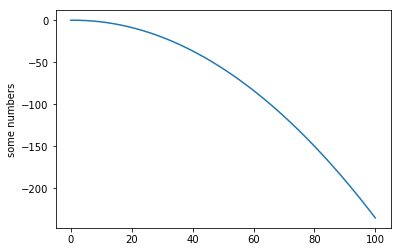

In [56]:
import matplotlib.pyplot as plt
plt.plot(x_values, y_values )
plt.ylabel('some numbers')
plt.show()


In [7]:
A =np.zeros((6,6))

running_sum = 0
for k in range(6):
#     increment = 1/6
    increment = (k+1)
    A[0,k] = increment
    running_sum += increment
A[0] *= 1/running_sum
    

for j in range(6-1):
    A[j+1,j] = 1
    
A

C =np.zeros((6,6))

running_sum = 0
for k in range(6):
#     increment = 1/6
    increment = (k+1)
    C[-1,k] = increment
    running_sum += increment
C[-1] *= 1/running_sum
    

for j in range(6-1):
    C[j,j+1] = 1
    
C

array([[ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.048,  0.095,  0.143,  0.19 ,  0.238,  0.286]])

In [9]:
C.T

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.048],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.095],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.143],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.19 ],
       [ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.238],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.286]])

In [11]:
A

array([[ 0.048,  0.095,  0.143,  0.19 ,  0.238,  0.286],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ]])

In [12]:
np.poly(A)

array([ 1.   , -0.048, -0.095, -0.143, -0.19 , -0.238, -0.286])

In [10]:
np.poly(C)

array([ 1.   , -0.286, -0.238, -0.19 , -0.143, -0.095, -0.048])

In [13]:
ones_v = np.ones(6)

In [14]:
A @ ones_v

array([ 1.,  1.,  1.,  1.,  1.,  1.])

In [15]:
Q, R =np.linalg.qr(A - np.eye(6))
steady_state = Q[:,-1]
steady_state *= 1/ np.sum(steady_state)

In [16]:
steady_state

array([ 0.231,  0.22 ,  0.198,  0.165,  0.121,  0.066])

In [17]:
counter = np.arange(6)+1
counter

array([1, 2, 3, 4, 5, 6])

In [18]:
A

array([[ 0.048,  0.095,  0.143,  0.19 ,  0.238,  0.286],
       [ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ]])

In [19]:
mu = (A @ counter)[0]
mu

4.333333333333333

In [32]:
steady_state*mu

array([ 1.   ,  0.952,  0.857,  0.714,  0.524,  0.286])

In [21]:
A.T

array([[ 0.048,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.095,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.143,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.19 ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.238,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.286,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [27]:
2/7

0.2857142857142857

In [22]:
steady_state @ A


array([ 0.231,  0.22 ,  0.198,  0.165,  0.121,  0.066])

In [23]:
steady_state @ A @ A

array([ 0.231,  0.22 ,  0.198,  0.165,  0.121,  0.066])

In [24]:
ones_v = np.ones(6)
right_vec = ones_v / np.sum(ones_v)

In [25]:
e1 = np.zeros(6)
e1[0]=1
e1

array([ 1.,  0.,  0.,  0.,  0.,  0.])

In [26]:
x = e1
# x = np.ones(6)/6
for _ in range(1000):
    b = A @ x
    x = b
x

array([ 0.231,  0.231,  0.231,  0.231,  0.231,  0.231])

In [27]:
A.T

array([[ 0.048,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.095,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.143,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.19 ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.238,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.286,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [28]:
np.sum(x)

1.3846153846153813

In [29]:
A @ right_vec

array([ 0.167,  0.167,  0.167,  0.167,  0.167,  0.167])

In [30]:
A @ steady_state

array([ 0.139,  0.231,  0.22 ,  0.198,  0.165,  0.121])

In [28]:
A.T

array([[ 0.167,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.167,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.167,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.167,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.167,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.167,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [25]:
np.abs(np.linalg.eigvals(A))

array([ 1.   ,  0.73 ,  0.73 ,  0.67 ,  0.683,  0.683])

array([ 0.408,  0.408,  0.408,  0.408,  0.408,  0.408])